In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
beneficiary = pd.read_csv("/content/sample_data/Beneficiarydata.csv")
in_patient = pd.read_csv("/content/sample_data/Inpatientdata.csv")
out_patient = pd.read_csv("/content/sample_data/Outpatientdata.csv")
provider = pd.read_csv("/content/sample_data/Provider.csv")

# Checking for null values in all the tables

In [5]:
tables = {
    "Beneficiary": beneficiary,
    "In_patient": in_patient,
    "Out_patient": out_patient,
    "Provider": provider
}

# Loop through each dataframe and check for null values
for name, df in tables.items():
    print(f"\nNull values in {name} table:")
    print(df.isnull().sum())


Null values in Beneficiary table:
BeneID                                 0
DOB                                    0
DOD                                63394
Gender                                 0
Race                                   0
RenalDiseaseIndicator                  0
State                                  0
County                                 0
NoOfMonths_PartACov                    0
NoOfMonths_PartBCov                    0
ChronicCond_Alzheimer                  0
ChronicCond_Heartfailure               0
ChronicCond_KidneyDisease              0
ChronicCond_Cancer                     0
ChronicCond_ObstrPulmonary             0
ChronicCond_Depression                 0
ChronicCond_Diabetes                   0
ChronicCond_IschemicHeart              0
ChronicCond_Osteoporasis               0
ChronicCond_rheumatoidarthritis        0
ChronicCond_stroke                     0
IPAnnualReimbursementAmt               0
IPAnnualDeductibleAmt                  0
OPAnnualReimbursementA

In [6]:
# Here we can there are no null values in primary key cols of the table

In [7]:
# These are the required features to be included.


# Target Variable: Flag claims as fraudulent or non-fraudulent (based on provided or derived labels).


# Features to include:
# Claim amount (InscClaimAmtReimbursed)
# Provider ID
# Number of physicians involved
# Chronic conditions
# Claim type (inpatient / outpatient)

In [8]:
# In order to have these features we need a summary table where we can only have these particular cols

In [9]:
# Adding a claim type column to both the in_patient and out_patient table
in_patient["ClaimType"] = "Inpatient"
out_patient["ClaimType"] = "Outpatient"

In [10]:
# Adding a physician count column to both the in_patient and out_patient table
def count_physicians(row):
  return sum([ pd.notna(row.get("AttendingPhysician")),
               pd.notna(row.get("OperatingPhysician")),
               pd.notna(row.get("OtherPhysician"))
            ])

in_patient["NumPhysicians"] = in_patient.apply(count_physicians, axis=1)
out_patient["NumPhysicians"] = out_patient.apply(count_physicians, axis=1)

In [11]:
# Selecting the relevant columns
in_patient_sel = in_patient[["BeneID", "ClaimID", "InscClaimAmtReimbursed", "Provider", "NumPhysicians", "ClaimType"]]
out_patient_sel = out_patient[["BeneID", "ClaimID", "InscClaimAmtReimbursed", "Provider", "NumPhysicians", "ClaimType"]]

In [12]:
# Combine inpatient and outpatient
claims = pd.concat([in_patient_sel, out_patient_sel], ignore_index=True)

In [13]:
# Here we now have a combined claims table from both in_patient and out_patient tables
claims.head()


,BeneID,ClaimID,InscClaimAmtReimbursed,Provider,NumPhysicians,ClaimType
0,BENE11014,CLM67387,9000,PRV57070,2,Inpatient
1,BENE11017,CLM31237,14000,PRV54750,2,Inpatient
2,BENE11026,CLM78930,2000,PRV53758,1,Inpatient
3,BENE11031,CLM56810,16000,PRV55825,2,Inpatient
4,BENE11085,CLM34625,19000,PRV52338,1,Inpatient


In [14]:
# Now we will merge the claims table with beneficiary

# Here we will create the chronic condition col.

chronic_cols = [ "ChronicCond_Alzheimer",
                 "ChronicCond_Heartfailure",
                 "ChronicCond_KidneyDisease",
                 "ChronicCond_Cancer",
                 "ChronicCond_ObstrPulmonary",
                 "ChronicCond_Depression",
                 "ChronicCond_Diabetes",
                 "ChronicCond_IschemicHeart",
                 "ChronicCond_Osteoporasis",
                 "ChronicCond_rheumatoidarthritis",
                 "ChronicCond_stroke" ]

# This is our final summary table after pulling data from all the tables

df = claims.merge(beneficiary[["BeneID", "Gender", "Race"] + chronic_cols], on = "BeneID", how = "left")
df.head()

,BeneID,ClaimID,InscClaimAmtReimbursed,Provider,NumPhysicians,ClaimType,Gender,Race,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,BENE11014,CLM67387,9000,PRV57070,2,Inpatient,2,1,2,1,1,2,1,1,2,1,2,2,2
1,BENE11017,CLM31237,14000,PRV54750,2,Inpatient,2,1,1,1,1,1,1,2,1,1,2,1,1
2,BENE11026,CLM78930,2000,PRV53758,1,Inpatient,1,1,2,2,2,2,2,2,2,1,2,2,2
3,BENE11031,CLM56810,16000,PRV55825,2,Inpatient,2,1,2,1,1,2,2,2,2,1,1,2,2
4,BENE11085,CLM34625,19000,PRV52338,1,Inpatient,2,1,1,1,1,1,1,1,1,1,1,2,2


In [15]:
# Now we need to create a col that flags claims
# It wil tell us if the claims are approved or not

df["ClaimApproved"] = df["InscClaimAmtReimbursed"].apply(lambda x: 1 if x > 0 else 0)

In [16]:
df["ClaimApproved"].value_counts()

,count
ClaimApproved,
1,130469
0,4923


In [17]:
# Here we can see the distribution of Approved (x = 1) and not (x = 0) claims

In [18]:
df.head()

,BeneID,ClaimID,InscClaimAmtReimbursed,Provider,NumPhysicians,ClaimType,Gender,Race,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimApproved
0,BENE11014,CLM67387,9000,PRV57070,2,Inpatient,2,1,2,1,1,2,1,1,2,1,2,2,2,1
1,BENE11017,CLM31237,14000,PRV54750,2,Inpatient,2,1,1,1,1,1,1,2,1,1,2,1,1,1
2,BENE11026,CLM78930,2000,PRV53758,1,Inpatient,1,1,2,2,2,2,2,2,2,1,2,2,2,1
3,BENE11031,CLM56810,16000,PRV55825,2,Inpatient,2,1,2,1,1,2,2,2,2,1,1,2,2,1
4,BENE11085,CLM34625,19000,PRV52338,1,Inpatient,2,1,1,1,1,1,1,1,1,1,1,2,2,1


In [19]:
# Now we need to do some EDA on this dataset

In [20]:
df["Gender"].value_counts()

,count
Gender,
2,78017
1,57375


In [21]:
# Here in the Gender col (1 = Male and 2 = Female)

# EDA

## Univariarte Analysis

In [22]:
Male = len(df[df["Gender"] == 1])
Female = len(df[df["Gender"] == 2])

print("Percentage of Male patient is {:.2f}%".format(Male/len(df.Gender)*100))
print("Percentage of Female patient is {:.2f}%".format(Female/len(df.Gender)*100))

Percentage of Male patient is 42.38%
Percentage of Female patient is 57.62%


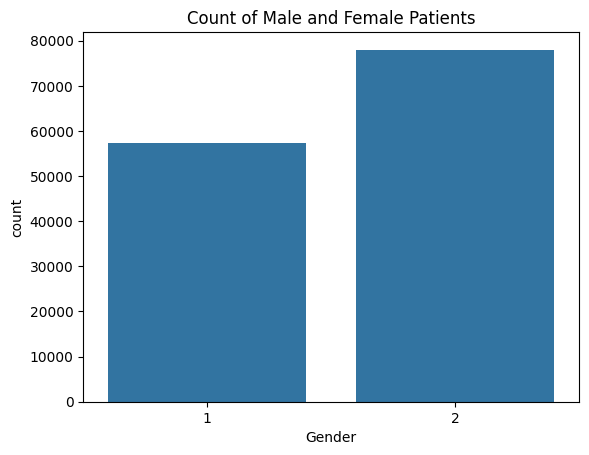

In [23]:
sns.countplot(x = "Gender", data = df)
plt.title("Count of Male and Female Patients")
plt.show()

In [24]:
# In the above graph we can see there are more "Female" patients than male.

In [25]:
df["ClaimApproved"].value_counts()

,count
ClaimApproved,
1,130469
0,4923


In [26]:
claims_approved = len(df[df["ClaimApproved"] == 1])
claims_not_approved = len(df[df["ClaimApproved"] == 2])

print("Percentage of claims approved is {:.2f}%".format(Male/len(df.Gender)*100))
print("Percentage of claims not approved is {:.2f}%".format(Female/len(df.Gender)*100))

Percentage of claims approved is 42.38%
Percentage of claims not approved is 57.62%


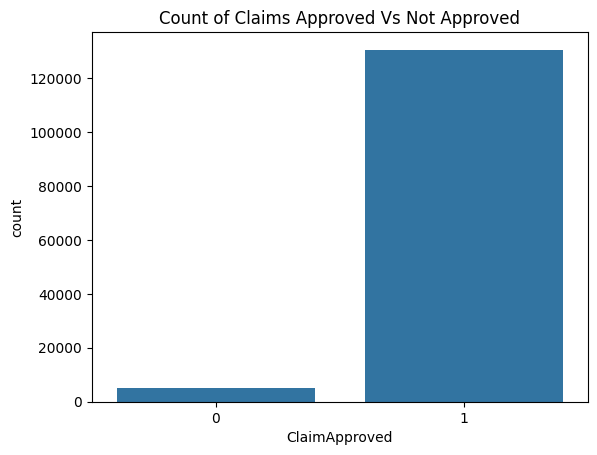

In [27]:
sns.countplot(x = "ClaimApproved", data = df)
plt.title("Count of Claims Approved Vs Not Approved")
plt.show()

In [28]:
df["Race"].value_counts()

,count
Race,
1,115067
2,13496
3,4118
5,2711


In [29]:
# Percentage of different races r1, r2, r3, r4

r1 = len(df[df["Race"] == 1])
r2 = len(df[df["Race"] == 2])
r3 = len(df[df["Race"] == 3])
r4 = len(df[df["Race"] == 4])

print("Percentage of r1 patient is {:.2f}%".format(r1/len(df.Race)*100))
print("Percentage of r2 patient is {:.2f}%".format(r2/len(df.Race)*100))
print("Percentage of r3 patient is {:.2f}%".format(r3/len(df.Race)*100))
print("Percentage of r4 patient is {:.2f}%".format(r4/len(df.Race)*100))

Percentage of r1 patient is 84.99%
Percentage of r2 patient is 9.97%
Percentage of r3 patient is 3.04%
Percentage of r4 patient is 0.00%


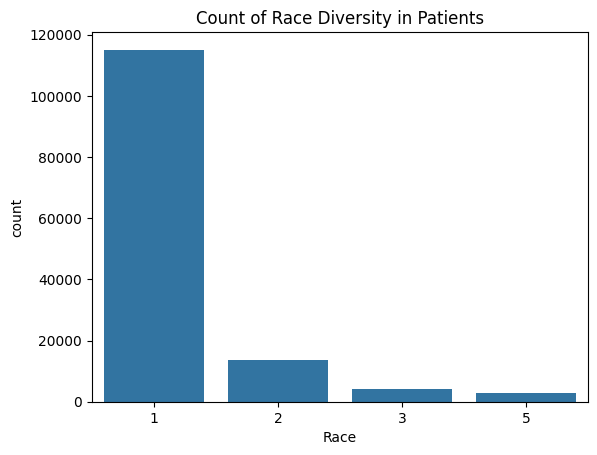

In [30]:
sns.countplot(x = "Race", data = df)
plt.title("Count of Race Diversity in Patients")
plt.show()

In [31]:
df.describe()

,InscClaimAmtReimbursed,NumPhysicians,Gender,Race,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimApproved
count,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000,135392.000000
mean,981.307906,1.557478,1.576231,1.240605,1.596727,1.405504,1.584052,1.845235,1.688312,1.567463,1.291745,1.240383,1.683637,1.689923,1.895422,0.963639
std,3788.177532,0.636914,0.494157,0.695578,0.490557,0.490991,0.492886,0.361682,0.463185,0.495430,0.454567,0.427318,0.465058,0.462527,0.306010,0.187188
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,40.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000
50%,80.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000
75%,300.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000
max,125000.000000,3.000000,2.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000


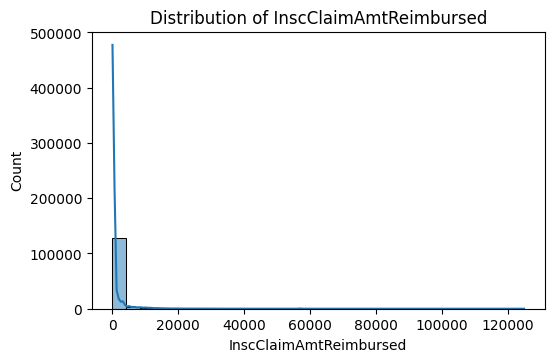

In [32]:
plt.figure(figsize=(15, 10))
cols = ['InscClaimAmtReimbursed']

for i in range(len(cols)):
    plt.subplot(3, 3, i + 1)  # 3 rows × 3 cols grid
    sns.histplot(df[cols[i]], kde = True, bins = 30)
    plt.title(f'Distribution of {cols[i]}')

plt.tight_layout()
plt.show()

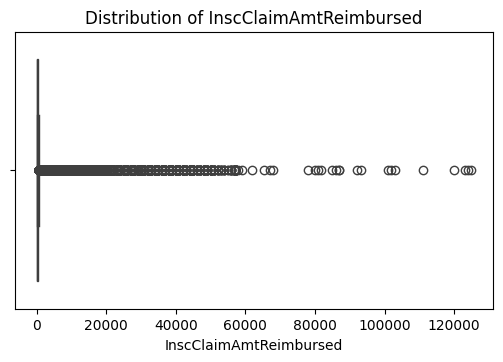

In [33]:
plt.figure(figsize=(15, 10))
cols = ['InscClaimAmtReimbursed']

for i in range(len(cols)):
    plt.subplot(3, 3, i + 1)  # 3 rows × 3 cols grid
    sns.boxplot(x = df[cols[i]])
    plt.title(f'Distribution of {cols[i]}')

plt.tight_layout()
plt.show()

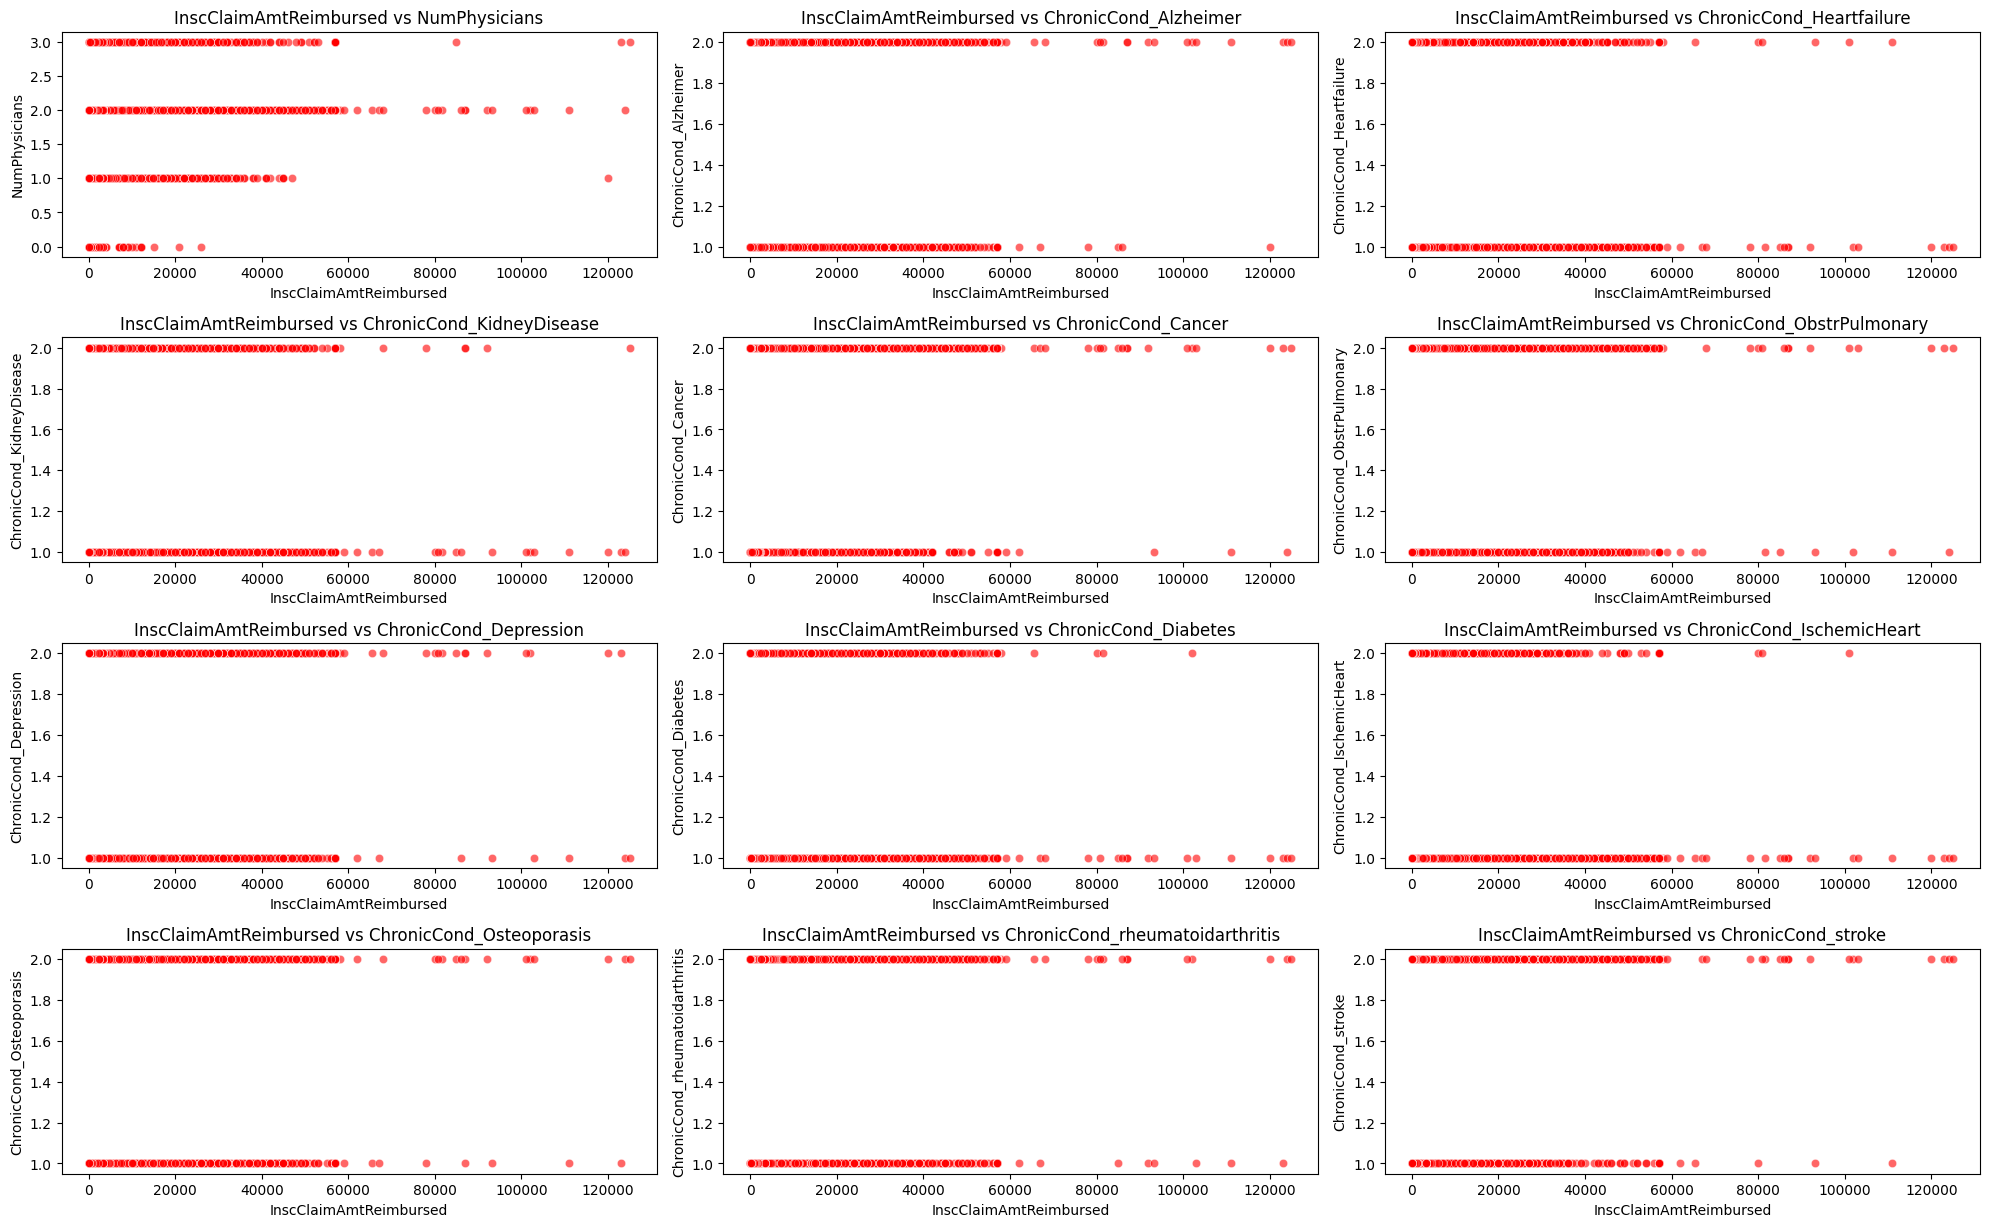

In [34]:
plt.figure(figsize=(20, 15))
cols = [
        'NumPhysicians',
        'ChronicCond_Alzheimer',
        'ChronicCond_Heartfailure',
        'ChronicCond_KidneyDisease',
        'ChronicCond_Cancer',
        'ChronicCond_ObstrPulmonary',
        'ChronicCond_Depression',
        'ChronicCond_Diabetes',
        'ChronicCond_IschemicHeart',
        'ChronicCond_Osteoporasis',
        'ChronicCond_rheumatoidarthritis',
        'ChronicCond_stroke'
        ]

for i in range(len(cols)):
    plt.subplot(5, 3, i + 1)  # 3 rows × 3 cols grid
    sns.scatterplot(data = df, x = 'InscClaimAmtReimbursed', y = cols[i], color = 'r', alpha = 0.6)
    plt.title(f'InscClaimAmtReimbursed vs {cols[i]}')

plt.tight_layout()
plt.show()

## Multivariate Analysis

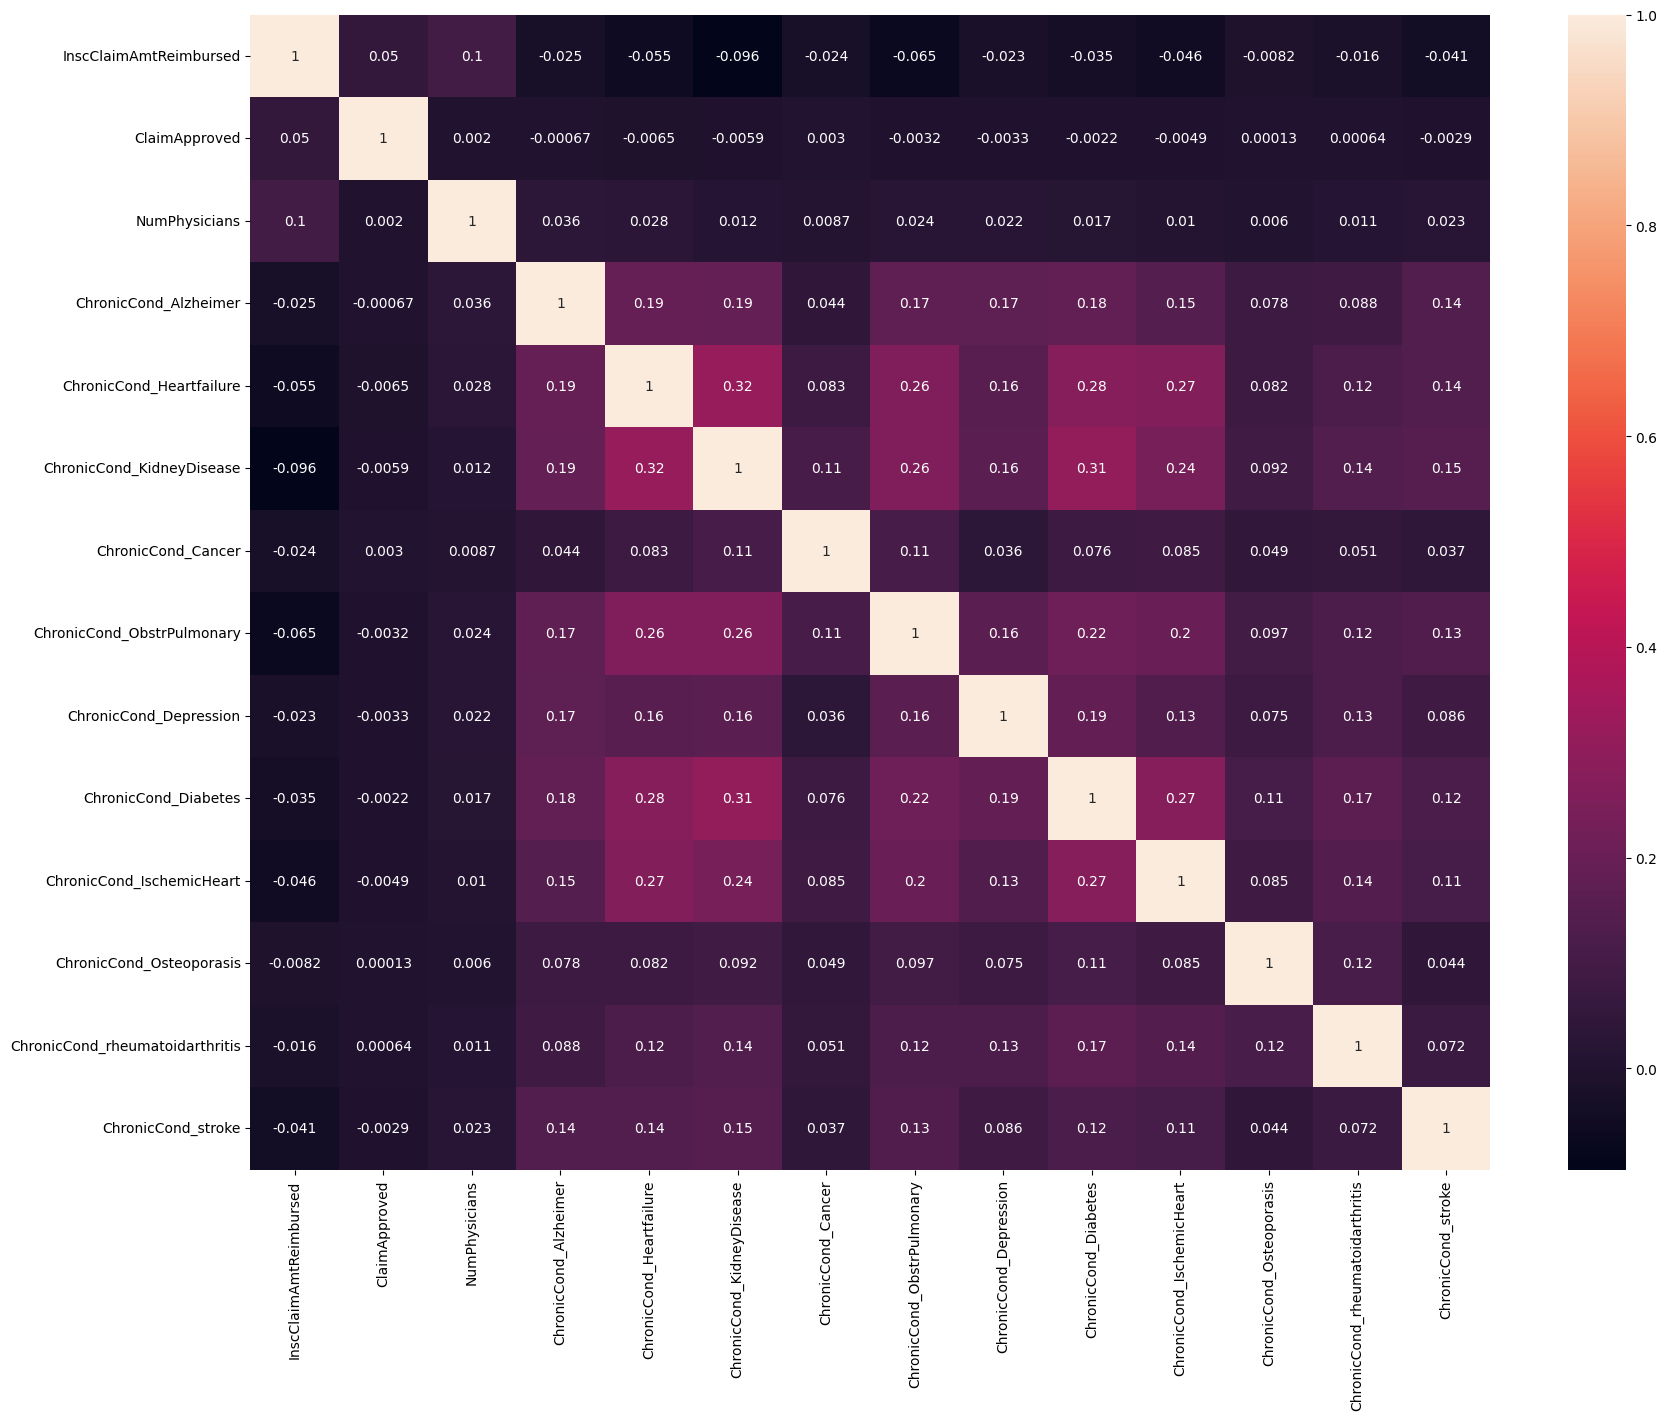

In [35]:
# Correlation Table - Heat Map
plt.figure(figsize=(20, 15))

cols = ['InscClaimAmtReimbursed',
        'ClaimApproved',
        'NumPhysicians',
        'ChronicCond_Alzheimer',
        'ChronicCond_Heartfailure',
        'ChronicCond_KidneyDisease',
        'ChronicCond_Cancer',
        'ChronicCond_ObstrPulmonary',
        'ChronicCond_Depression',
        'ChronicCond_Diabetes',
        'ChronicCond_IschemicHeart',
        'ChronicCond_Osteoporasis',
        'ChronicCond_rheumatoidarthritis',
        'ChronicCond_stroke']

sns.heatmap(data = df[cols].corr(), annot = True, cmap = 'rocket')
plt.show()

# Data Preprocessing

In [36]:
model_data = df.copy()

In [37]:
# Removing unnesecary cols
model_data.columns

Index(['BeneID', 'ClaimID', 'InscClaimAmtReimbursed', 'Provider',
       'NumPhysicians', 'ClaimType', 'Gender', 'Race', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'ClaimApproved'],
      dtype='object')

In [38]:
model_data = model_data.drop(["BeneID", "ClaimID"], axis=1)

In [39]:
model_data.columns

Index(['InscClaimAmtReimbursed', 'Provider', 'NumPhysicians', 'ClaimType',
       'Gender', 'Race', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'ClaimApproved'],
      dtype='object')

In [40]:
# Removing Null Values
model_data.isnull().sum()

,0
InscClaimAmtReimbursed,0
Provider,0
NumPhysicians,0
ClaimType,0
Gender,0
Race,0
ChronicCond_Alzheimer,0
ChronicCond_Heartfailure,0
ChronicCond_KidneyDisease,0
ChronicCond_Cancer,0


In [41]:
model_data.columns

Index(['InscClaimAmtReimbursed', 'Provider', 'NumPhysicians', 'ClaimType',
       'Gender', 'Race', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'ClaimApproved'],
      dtype='object')

# Data Transformation

In [42]:
model_data["InscClaimAmtReimbursed"] = np.log1p(model_data["InscClaimAmtReimbursed"])


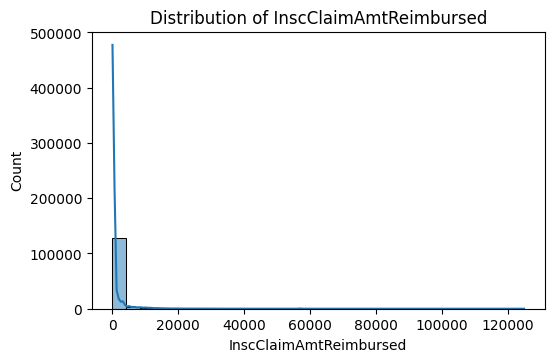

In [43]:
plt.figure(figsize=(15, 10))
cols = ['InscClaimAmtReimbursed']

for i in range(len(cols)):
    plt.subplot(3, 3, i + 1)  # 3 rows × 3 cols grid
    sns.histplot(df[cols[i]], kde = True, bins = 30)
    plt.title(f'Distribution of {cols[i]}')

plt.tight_layout()
plt.show()

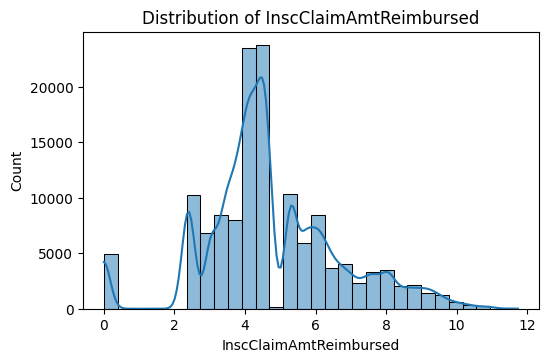

In [44]:

plt.figure(figsize=(15, 10))
cols = ['InscClaimAmtReimbursed']

for i in range(len(cols)):
    plt.subplot(3, 3, i + 1)  # 3 rows × 3 cols grid
    sns.histplot(model_data[cols[i]], kde = True, bins = 30)
    plt.title(f'Distribution of {cols[i]}')

plt.tight_layout()
plt.show()

In [45]:
# We can see that earlier the data did not had a normal distribution now it follows a somehow normal distribution.

In [48]:
model_data = pd.get_dummies(model_data, dtype = int)

In [49]:
# Feature separation - x and y (Target variable and independent variable)
x = model_data.drop(["ClaimApproved"], axis =1)
y = model_data["ClaimApproved"]

In [51]:
x,y = SMOTE().fit_resample(x,y)

<Axes: xlabel='count', ylabel='ClaimApproved'>

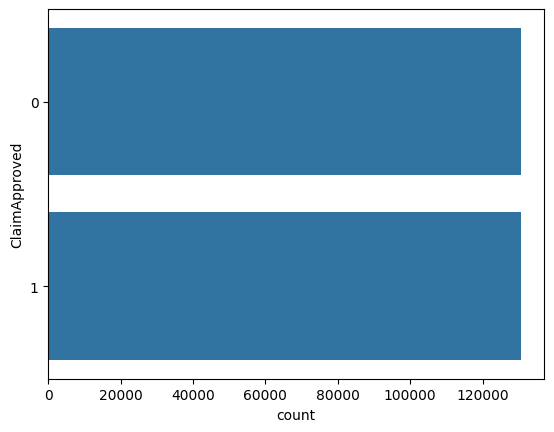

In [52]:
sns.countplot(y = y, data = model_data)

In [50]:
x = MinMaxScaler().fit_transform(x)
x

array([[0.77582066, 0.66666667, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.81346467, 0.66666667, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.64769533, 0.33333333, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.29260094, 0.33333333, 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.29260094, 0.66666667, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.66670029, 0.33333333, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [53]:
#Train test split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

In [54]:
#Modelling:

#Logistic regression

classifier = LogisticRegression(solver = 'saga', max_iter = 500, random_state= 1)

classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26114
           1       1.00      1.00      1.00     26074

    accuracy                           1.00     52188
   macro avg       1.00      1.00      1.00     52188
weighted avg       1.00      1.00      1.00     52188



In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Create the model
dt_classifier = DecisionTreeClassifier(random_state=1)

# Train
dt_classifier.fit(x_train, y_train)

# Predict
y_pred_dt = dt_classifier.predict(x_test)

# Evaluation
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26114
           1       1.00      1.00      1.00     26074

    accuracy                           1.00     52188
   macro avg       1.00      1.00      1.00     52188
weighted avg       1.00      1.00      1.00     52188



In [56]:
from sklearn.ensemble import RandomForestClassifier

# Create the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)

# Train
rf_classifier.fit(x_train, y_train)

# Predict
y_pred_rf = rf_classifier.predict(x_test)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26114
           1       1.00      1.00      1.00     26074

    accuracy                           1.00     52188
   macro avg       1.00      1.00      1.00     52188
weighted avg       1.00      1.00      1.00     52188

